# Comparison of different VRP reformulations

In [1]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
from IPython.display import IFrame
import random
random.seed(26)

%load_ext autoreload
%autoreload 2

# Introduction:

In this notebook I implemented the three models introduced and discussed in the paper of Lahyani et al.(2018) using Gurobi Python API and compared the results of the three models. 

### Problem description:
The problem discussed here is the multi-depot fleet size and mix vehicle routing problem (MDFSMVRP). The solution of the problem can be defined as a directed graph $G = (V, A)$ with V being the vertex set and A being the arc set. 

### Mathematical formulation:
- Each customer $i \in V_c$ has demand $q_i \geq 0$; each depot $i \in V_d$ has zero demand $q_i$ = 0
- Distance between $i,j \in V$ is $\beta_{ij}$ ; here we assume cost is positively reltated to distance
- Loop arcs $(i,i)$ is not allowed: $\beta_{ii} = \inf \quad \forall i \in V_c$
- Depots cannot be connected to depots: $\beta_{ij} = \inf \quad \forall i,j \in V_d, i \neq j$
- Different depots house heterogeneous vehicles $K = {1,...,K}$ with accroding capacity $Q^K$, fixed cost $F^K$, and a variable cost $\alpha^K$

# All models (F1~F5)

Here I briefly demonstrated each of the five models(F1~F5) covered in paper of Lahyani et al.(2018) and explaned the decision varaibles each model used, the objective function each model minimized, and the constraints each model had. The first two models are already covered in class and their transformations are also done in exercise3, so I focused more on the last three models. 

## F1. Three-index VRP Formulation (from class)

### Decision variables:
Assignment of location i to tour k: $y_{ik} \in \{0, 1\}$ ($y_{ik} = 1$ if location i is assigned to tour k; $ = 0$ otherwise)

Order variables: $x_{ijk} \in \{0, 1\}$ ($x_{ijk} = 1$ if tour k directs from location i to j; $ = 0$ otherwise)

### Objective Function:
Minimize $\sum_{k \in K} \sum_{i \in V} \sum_{j\in V} d_{ij} x_{ijk}$

###  subject to:

$\sum_{i\in V} x_{ijk} = y_{jk} \qquad \forall j \in V_c; k \in K \qquad$ node assignment constraint (reach once)

$\sum_{j\in V} x_{ijk} = y_{ik} \qquad \forall i \in V_c; k \in K \qquad$ node assignment constraint (depart once)

$z_i - z_j + n\sum_{k \in K}x_{ijk} \leq n - 1 \qquad \forall i, j \in V_c; i \neq j \qquad$ subtour elimination

$\sum_{k \in K} y_{ik} = 1 \qquad \forall i \in V_c \qquad$ assignment constraint

$\sum_{k \in K} y_{0k} = K \qquad$ assignment constraint

$\sum_{i \in V_c} q_i y_{ik} \leq Q \qquad \forall k \in K \qquad$ capacity constraint

$\sum_{i \in V} \sum_{j \in V} d_{ij} x_{ijk} \leq T \qquad \forall k \in K \qquad$ time constraint

$y_{ik} \in \{0, 1\},\quad x_{ijk} \in \{0, 1\} \qquad \forall i, j \in V, k \in K \qquad$

## F2. Two-index VRP Formulation (from class)

### Decision variables:
Load transported from i to j: $y_{ij}$

Driving from i to j: $x_{ij} \in \{0, 1\}$ ($x_{ij} = 1$ if a tour directs from location i to j; $ = 0$ otherwise)

### Objective Function:
Minimize $\sum_{i \in V} \sum_{j \in V} d_{ij} x_{ij}$

###  subject to:

$\sum_{i \in V} x_{ij} = 1 \qquad \forall j \in V_c \qquad$ node assignment constraint (reach once)

$\sum_{j \in V} x_{ij} = 1 \qquad \forall i \in V_c \qquad$ node assignment constraint (depart once)

$\sum_{i \in V} x_{i0} = \sum_{j \in V} x_{0j} \leq K \qquad$ total number of tours

$\sum_{i \in V} y_{ij} - \sum_{i \in V} y_{ji} = b_j \qquad \forall j \in V_c \qquad$ demand satisfaction

$\sum_{j \in V} y_{0j} = \sum_{j \in V_c} b_j \qquad$ total demand

$q_j x_{ij} \leq y_ij \leq (Q - q_i)x_{ij} \qquad \forall i, j \in V \qquad$ transportation capacity

$y_{j0} = 0 \qquad \forall j \in V \qquad$ empty vehicle when returning back to depot

$y_{ij} \geq 0,\quad x_{ij} \in \{0, 1\} \qquad \forall i, j \in V \qquad$

The main problem with F1 and F2 is that they will not scale well because some of their constraints scales in the order of $O(2^n)$. Therefore, they will not perform well when the problem instance is too large.

## F3. Commodity flow model + multiple depots

### Decision variables:
Arc assignment: $x_{ij}^{kd} \in \{0, 1\}$ ( $x_{ij}^{kd} = 1$ if arc(i, j) is assigned to vehicle type k from depot d; $= 0$ otherwise)

Node assignment: $y_i^{kd} \in \{0, 1\}$ ( $y_i^{kd} = 1$ if node i is visited by vehicle type k from depot d; $= 0$

Remaining load: $z_{ij} \geq 0$

### Objective Function:
Minimize $\sum_{i \in V_c} \sum_{k \in K} \sum_{d \in V_d} F^k x_{di}^{kd} + \sum_{(i, j) \in A} \sum_{k \in K} \sum_{d \in V_d} \alpha^k \beta_{ij} x_{ij}^{kd}$

###  subject to:

(1) $\sum_{k \in K} \sum_{d \in V_d} y_{i}^{kd} = 1 \qquad \forall i \in V_c \qquad$ assignment constraint

(2) $y_i^{kd} \leq y_d^{kd} \qquad \forall i \in V_c, k \in K, d \in V_d \qquad$ same vehicle same depot

(3) $\sum_{j \in V} x_{ij}^{kd} \sum_{j \in V} x_{ij}^{kd} = 2y_i^{kd} \qquad \forall i \in V_c, k \in K, d \in V_d \qquad$ link x and y

(4) $\sum_{i \in V} x_{ij}^{kd} = \sum_{i \in V} x_{ji}^{kd} \qquad \forall j \in V, k \in K, d \in V_d \qquad$ flow constraint

(5) $y_d^{kd} \leq \sum_{(i, j) \in A} x_{ij}^{kd} \qquad \forall k \in K, d \in V_d \qquad$ only used vehicle can be assigned

(6) $2y_d^{kd} \leq \sum_{j \in V_c} x_{jd}^{kd} + \sum_{j \in V_c}x_{dj}^{kd} \qquad \forall k \in K, d \in V_d \qquad$ only used vehicle can be assigned

(7) $\sum_{i \in V} z_{ij} - \sum_{i \in V} z_{ji} = q_j \qquad \forall j \in V_c \qquad$ demand satisfaction

(8) $\sum_{i \in V_d} \sum_{j \in V_c} z_ij = \sum_{j \in V_c} q_j \qquad$ total load shiped out from depots = total demand

(9) $z_{ij} \leq \sum_{k \in K} \sum_{j \in V_c} (Q^k - q_i) x_{ij}^{kd} \qquad \forall i \in V, j \in V_c \qquad$ capacity constraint

$x_{ij}^{kd} \in \{0, 1\} \qquad \forall (i, j) \in A, k \in K, d \in V_d \qquad$
 
$y_{i}^{kd} \in \{0, 1\} \qquad \forall i \in V, k \in K, d \in V_d \qquad$

$z_{ij} \geq 0 \qquad \forall (i, j) \in A, k \in K, d \in V_d \qquad$

In [4]:
def run_F3(network, vertices, arcs, V_d, V_c, F, alpha, K, Q, runtime_limit=1800):
    model = gp.Model("Compact formulation with loading variables")

    # Model Parameters(Stopping Condition)
    model.Params.TimeLimit = runtime_limit
    # model.Params.MIPGap = 3e-2

    # Decision Variables
    x = model.addVars(vertices, vertices, K, V_d, vtype=GRB.BINARY, name="Routing")
    y = model.addVars(vertices, K, V_d, vtype=GRB.BINARY, name="Assignment")
    z = model.addVars(vertices, vertices)

    ## fixed cost
    FC = gp.quicksum(gp.quicksum(gp.quicksum(F * x[d, i, k, d]
                                             for d in V_d)
                                 for k in K)
                     for i in V_c)
    ## variable cost
    VC = gp.quicksum(gp.quicksum(gp.quicksum(alpha[k] * network.route_dict[i, j].dist_total * x[i, j, k, d]
                                             for d in V_d)
                                 for k in K)
                     for (i, j) in arcs)

    # Objective => minimize fixed cost + variable cost
    model.setObjective(VC + FC, GRB.MINIMIZE)

    # Original constraints without additional bounding constraints:

    ## (1) assignment constraint
    model.addConstrs(gp.quicksum(gp.quicksum(y[i, k, d]
                                             for d in V_d)
                                 for k in K) == 1
                     for i in V_c)

    ## (2) same vehicle same depot
    model.addConstrs(y[i, k, d] <= y[d, k, d] for i in V_c for k in K for d in V_d)

    ## (3) link y and x together
    model.addConstrs(
        gp.quicksum(x[i, j, k, d] for j in vertices) + gp.quicksum(x[j, i, k, d] for j in vertices) == 2 * y[i, k, d]
        for i in V_c for k in K for d in V_d)

    ## (4) flow constraint
    model.addConstrs(gp.quicksum(x[i, j, k, d] for i in vertices) == gp.quicksum(x[j, i, k, d] for i in vertices)
                     for j in vertices for k in K for d in V_d)

    ## (5) vehicle assignment constraint
    model.addConstrs(y[d, k, d] <= gp.quicksum(x[i, j, k, d] for (i, j) in arcs)
                     for k in K for d in V_d)

    ## (6) vehicle assignment constraint
    model.addConstrs(2 * y[d, k, d] <= gp.quicksum(x[j, d, k, d] for j in V_c) + gp.quicksum(x[d, j, k, d] for j in V_c)
                     for k in K for d in V_d)

    ## (7) demand satisfaction
    model.addConstrs(
        gp.quicksum(z[i, j] for i in vertices) - gp.quicksum(z[j, i] for i in vertices) == network.node_dict[j].d_w
        for j in V_c)

    ## (8) total load transported from depots == total demand of all customers
    model.addConstr(
        gp.quicksum(gp.quicksum(z[i, j] for j in V_c) for i in V_d) == gp.quicksum(network.node_dict[j].d_w for j in V_c)
    )

    ## (9) capacity constraint
    model.addConstrs(
        z[i, j] <= gp.quicksum(gp.quicksum((Q[k] - network.node_dict[i].d_w) * x[i, j, k, d] for d in V_d) for k in K)
        for i in vertices for j in V_c)

    model.optimize()

    # Objective Value:
    objective_value = model.getObjective().getValue()
    print(f"Objective: {objective_value}")

    # Solution Routes:
    solution_F3 = []
    for (i, j) in arcs:
        for k in K:
            if x[i, j, k, "D0"].X == 1.0:
                print(i, j)
                solution_F3.append((i, j))
                
    # Save Runtime for comparison 
    runtime = model.Runtime
    

    model.dispose()
    return objective_value, solution_F3, runtime

## F4. Disaggregating the loading variables by vehicle type in F3

### Decision variables:
Arc assignment: $x_{ij}^{kd} \in \{0, 1\}$ ($x_{ij}^{kd} = 1$ if arc(i, j) is assigned to vehicle type k from depot d; $ = 0$ otherwise)

Node assignment: $y_i^{kd} \in \{0, 1\}$ ($y_i^{kd} = 1$ if node i is visited by vehicle type k from depot d; $ = 0$

Remaining load: $z_{ij}^k \geq 0$

### Objective Function:
Minimize $\sum_{i \in V_c} \sum_{k \in K} \sum_{d \in V_d} F^k x_{di}^{kd} + \sum_{(i, j) \in A} \sum_{k \in K} \sum_{d \in V_d} \alpha^k \beta_{ij} x_{ij}^{kd}$

###  subject to:

(1) $\sum_{k \in K} \sum_{d \in V_d} y_{i}^{kd} = 1 \qquad \forall i \in V_c \qquad$ assignment constraint

(2) $y_i^{kd} \leq y_d^{kd} \qquad \forall i \in V_c, k \in K, d \in V_d \qquad$ same vehicle same depot

(3) $\sum_{j \in V} x_{ij}^{kd} \sum_{j \in V} x_{ij}^{kd} = 2y_i^{kd} \qquad \forall i \in V_c, k \in K, d \in V_d \qquad$ link x and y

(4) $\sum_{i \in V} x_{ij}^{kd} = \sum_{i \in V} x_{ji}^{kd} \qquad \forall j \in V, k \in K, d \in V_d \qquad$ flow constraint

(5) $y_d^{kd} \leq \sum_{(i, j) \in A} x_{ij}^{kd} \qquad \forall k \in K, d \in V_d \qquad$ only used vehicle can be assigned

(6) $2y_d^{kd} \leq \sum_{j \in V_c} x_{jd}^{kd} + \sum_{j \in V_c}x_{dj}^{kd} \qquad \forall k \in K, d \in V_d \qquad$ only used vehicle can be assigned

(10) $\sum_{i \in V_d} \sum_{j \in V_c} \sum_{k \in K} z_{ij}^{k} = \sum_{j \in V_c} q_j \qquad$ total demand satisfaction

(11) $\sum_{i \in V} z_{ij}^{k} - \sum_{i \in V} z_{ji}^{k} = \sum_{d \in V_d} q_j y_j^{kd} \qquad \forall j \in V_c, k \in K \qquad$ customer demand satisfaction

(12) $z_{ij}^{k} \leq \sum_{d \in V_d} (Q^k - q_i) x_{ij}^{kd} \qquad \forall i \in V, j \in V_c, k \in K \qquad$ capacity constraint

$x_{ij}^{kd} \in \{0, 1\} \qquad \forall (i, j) \in A, k \in K, d \in V_d \qquad$
 
$y_{i}^{kd} \in \{0, 1\} \qquad \forall i \in V, k \in K, d \in V_d \qquad$

$z_{ij}^k \geq 0 \qquad \forall i, j \in V, k \in K \qquad$ variable domain

In [7]:
def run_F4(network, vertices, arcs, V_d, V_c, F, alpha, K, Q, runtime_limit=1800):
    model = gp.Model("Compact formulation with disaggregated loading variables")

    # Model Parameters(Stopping Condition)
    model.Params.TimeLimit = runtime_limit
    # model.Params.MIPGap = 3e-2

    # Decision Variables
    x = model.addVars(vertices, vertices, K, V_d, vtype=GRB.BINARY, name="Routing")
    y = model.addVars(vertices, K, V_d, vtype=GRB.BINARY, name="Assignment")
    z = model.addVars(vertices, vertices, K)

    ## fixed cost
    FC = gp.quicksum(gp.quicksum(gp.quicksum(F * x[d, i, k, d]
                                             for d in V_d)
                                 for k in K)
                     for i in V_c)
    ## variable cost
    VC = gp.quicksum(gp.quicksum(gp.quicksum(alpha[k] * network.route_dict[i, j].dist_total * x[i, j, k, d]
                                             for d in V_d)
                                 for k in K)
                     for (i, j) in arcs)

    # Objective => minimize fixed cost + variable cost
    model.setObjective(VC + FC, GRB.MINIMIZE)

    # Original constraints without additional bounding constraints:

    ## (1) assignment constraint
    model.addConstrs(gp.quicksum(gp.quicksum(y[i, k, d]
                                             for d in V_d)
                                 for k in K) == 1
                     for i in V_c)

    ## (2) same vehicle same depot
    model.addConstrs(y[i, k, d] <= y[d, k, d] for i in V_c for k in K for d in V_d)

    ## (3) link y and x together
    model.addConstrs(
        gp.quicksum(x[i, j, k, d] for j in vertices) + gp.quicksum(x[j, i, k, d] for j in vertices) == 2 * y[i, k, d]
        for i in V_c for k in K for d in V_d)

    ## (4) flow constraint
    model.addConstrs(gp.quicksum(x[i, j, k, d] for i in vertices) == gp.quicksum(x[j, i, k, d] for i in vertices)
                     for j in vertices for k in K for d in V_d)

    ## (5) vehicle assignment constraint
    model.addConstrs(y[d, k, d] <= gp.quicksum(x[i, j, k, d] for (i, j) in arcs)
                     for k in K for d in V_d)

    ## (6) vehicle assignment constraint
    model.addConstrs(2 * y[d, k, d] <= gp.quicksum(x[j, d, k, d] for j in V_c) + gp.quicksum(x[d, j, k, d] for j in V_c)
                     for k in K for d in V_d)

    ## (10) total load transported from depots == total demand of all customers
    model.addConstr(
        gp.quicksum(gp.quicksum(gp.quicksum(z[i, j, k]
                                            for k in K)
                                for j in V_c)
                    for i in V_d) ==
        gp.quicksum(network.node_dict[j].d_w for j in V_c))

    ## (11) customer demand satisfaction
    model.addConstrs(
        gp.quicksum(z[i, j, k] for i in vertices) - gp.quicksum(z[j, i, k] for i in vertices) == 
        gp.quicksum(network.node_dict[j].d_w * y[j, k, d] for d in V_d)
        for j in V_c for k in K)

    ## (12) capacity constraint
    model.addConstrs(z[i, j, k] <= gp.quicksum((Q[k] - network.node_dict[i].d_w) * x[i, j, k, d] for d in V_d)
                     for i in vertices for j in V_c for k in K)

    model.optimize()

    # Objective Value:
    objective_value = model.getObjective().getValue()
    print(f"Objective: {objective_value}")

    # Solution Routes:
    solution_F4 = []
    for (i, j) in arcs:
        for k in K:
            if x[i, j, k, "D0"].X == 1.0:
                print(i, j)
                solution_F4.append((i, j))

    # Save Runtime for comparison 
    runtime = model.Runtime
    
    model.dispose()
    return objective_value, solution_F4, runtime

## F5. Capacity-indexed formulation

### Decision variables:
Arc assignment: $x_{ij}^{kdq} \in \{0, 1\}$ ($x_{ij}^{kdq} = 1$ if vehicle type k from depot d traverses arc(i, j) with q units; $ = 0$ otherwise)

### Objective Function:
Minimize $\sum_{i \in V_c} \sum_{k \in K} \sum_{d \in V_d} \sum_{q = 1}^{Q^k} F^k x_{di}^{kdq} + \sum_{(i, j) \in A} \sum_{k \in K} \sum_{d \in V_d} \sum_{q = 0}^{Q^k} \alpha^k \beta_{ij} x_{ij}^{kdq}$

###  subject to:

(13) $\sum_{j \in V} \sum_{k \in K} \sum_{d \in V_d} \sum_{q = 1}^{Q^k} x_{ji}^{kdq} = 1 \qquad \forall i \in V_c \qquad$ assignment constraint

(14) $\sum_{i \in V_c} \sum_{q = 1}^{Q^k} x_{di}^{kdq} = \sum_{i \in V_c} x_{id}^{kd0} \qquad \forall k \in K, d \in V_d \qquad$ flow conservation

(15) $\sum_{j \in V} x_{ji}^{kdq} = \sum_{j \in V} x_{ij}^{kd(q - q_i)} \qquad \forall i \in V_c, k \in K, d \in V_d, q = \{q_i,...,Q^k\} \qquad$ capacity constraint

$x_{ij}^{kdq} \in \{0, 1\} \qquad \forall i, j \in V, k \in K, d \in V_d, q = \{0,...,Q^k\} \qquad$ variable domain

In [10]:
def run_F5(network, vertices, arcs, V_d, V_c, F, alpha, K, Q, runtime_limit=1800):
    model = gp.Model("Capacity-indexed formulation")

    # Model Parameters(Stopping Condition)
    model.Params.TimeLimit = runtime_limit
    # model.Params.MIPGap = 3e-2

    # Decision Variables
    x = {}
    for i in vertices:
        for j in vertices:
            for k in K:
                for d in V_d:
                    for q in range(0, Q[k] + 1):
                        x[i, j, k, d, q] = model.addVar(vtype=GRB.BINARY, name="Routing")

    ## fixed cost
    FC = gp.quicksum(gp.quicksum(gp.quicksum(gp.quicksum(F * x[d, i, k, d, q]
                                                         for q in range(1, Q[k] + 1))
                                             for d in V_d)
                                 for k in K)
                     for i in V_c)
    ## variable cost
    VC = gp.quicksum(gp.quicksum(gp.quicksum(gp.quicksum(alpha[k] * network.route_dict[i, j].dist_total * x[i, j, k, d, q]
                                                         for q in range(0, Q[k] + 1))
                                             for d in V_d)
                                 for k in K)
                     for (i, j) in arcs)

    # Objective => minimize fixed cost + variable cost
    model.setObjective(VC + FC, GRB.MINIMIZE)

    # Original constraints without additional bounding constraints:

    ## (13) assignment constraint
    model.addConstrs(gp.quicksum(gp.quicksum(gp.quicksum(gp.quicksum(x[j, i, k, d, q]
                                                                     for q in range(1, Q[k] + 1))
                                                         for d in V_d)
                                             for k in K)
                                 for j in vertices) == 1
                     for i in V_c)

    ## (14) flow conservation aand assigned vehicle number constraint
    model.addConstrs(gp.quicksum(gp.quicksum(x[d, i, k, d, q]
                                             for q in range(1, Q[k] + 1))
                                 for i in V_c) ==
                     gp.quicksum(x[i, d, k, d, 0] for i in V_c)
                     for k in K for d in V_d)

    ## (15) vehicle capacity requirement constraint
    model.addConstrs(
        gp.quicksum(x[j, i, k, d, q] for j in vertices) ==
        gp.quicksum(x[i, j, k, d, (q - network.node_dict[i].d_w)] for j in vertices)
        for i in V_c for k in K for d in V_d for q in range(network.node_dict[i].d_w, Q[k] + 1)

    model.optimize()

    # Objective Value:
    objective_value = model.getObjective().getValue()
    print(f"Objective: {objective_value}")

    # Solution Routes:
    solution_F5 = []
    for (i, j) in arcs:
        for k in K:
            for q in Q:
                if x[i, j, k, "D0", q].X == 1.0:
                    print(i, j)
                    solution_F5.append((i, j))

    # Save Runtime for comparison
    runtime = model.Runtime

    model.dispose()
    return objective_value, solution_F5, runtime

# Compare the model with different geographic datasets:

# Dataset description:

Here I applied two datasets on the three models to compare the results:

- Dataset 1 is from "Efficient Transport Solutions Ltd." case study conducted by Prof. Maximilian Schiffer, Gerhard Hiermann, Christina Liepold. The dataset consists of three geographic locations (i.e. Paris, Shanghai, New York), a corresponding depot in the city, more than 100 customer demand nodes per city, and seven types of vehicles with different capacity and cost. Because of computing capacity limitation, I limited the vehicle types to three and did not use the entire dataset; instead, I sampled a certain number of instances from the dataset, applied them to different models, and compared the result of objective values and time it takes for a corresponding model to solve the problem.

- Dataset 2 is a subset of the TSP dataset from the TSPLIB of University of Heidelberg. I coverted the dataset to a multi-depot fleet size and mix vehicle routing dataset with three different vehicle types and three different depots.

# - Datasets 1 (single depot fleet size and mix vehicle):

Dataset assumptions:
- there is only one depot per region
- there are only three types of vehicles
- capacity of the three types of vehicles are: 2800, 880, 670 (kg) respectively
- fixed cost in one region is the same for all types of vehicles: 156.393 in Paris, 41.576 in NewYork, 41.576 in Shanghai (\$)

In [2]:
# a class to load the "Efficient Transport Solutions Ltd." dataset
from instances.Data_loader import Data_loader
# a function class to visualize tours / routes on OpenStreetMap
from solutions.Visualization import visualize_tours

# a helper function to sample and generate a dataset
def generate_dataset(place="Paris", n_instance=30):
    data = Data_loader(place)
    network = data.data_network
    vehicles = data.data_original_vehicle
    param = data.data_param
    nodes = network.node_ids

    # select #n_instance of customer nodes from the dataset
    vertices = random.sample(list(network.node_ids[1:]), n_instance)
    # assume there is only one depot 
    vertices.insert(0, 'D0')
    
    # define the distance matrix as arcs
    arcs = []
    for i in vertices:
        for j in vertices:
            if i == j:
                continue
            route = network.route_dict[i, j]
            arcs.append((route.origin, route.dest))
    
    # define the depot node V_d
    V_d = [vertices[0]]
    # define other customer nodes V_c
    V_c = vertices[1:]
    
    # assume there are only three types of vehicles
    K = list(range(3))
    
    # define the capacity of all three types of vehicles
    Q = [2800, 880, 670]
    
    # assume fixed costs are the same for all types of vehicles
    F = param[0]
    
    # define variable costs for different types of vehicles
    alpha = np.array([17.5, 8, 5.9]) * param[2] / 100
    
    return network, vertices, arcs, V_d, V_c, F, alpha, K, Q

## 1. Paris Dataset:

### Load Paris Dataset with 30 nodes:

In [3]:
network, vertices, arcs, V_d, V_c, F, alpha, K, Q = generate_dataset("Paris", 30)
all_solutions = {}

### Run model F3 on Paris dataset:

In [5]:
objective_value, solution_F3, runtime = run_F3(network, vertices, arcs, V_d, V_c, F, alpha, K, Q)
all_solutions["F3_Paris_30"] = [objective_value, runtime]

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-21
Set parameter TimeLimit to value 1800
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1270 rows, 3937 columns and 19956 nonzeros
Model fingerprint: 0xafba0283
Variable types: 961 continuous, 2976 integer (2976 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 196 rows and 1846 columns
Presolve time: 0.11s
Presolved: 1074 rows, 2091 columns, 7657 nonzeros
Variable types: 900 continuous, 1191 integer (1191 binary)
Found heuristic solution: objective 4840.9885584
Found heuristic solution: objective 4732.1046720

Root relaxation: objective 9.024907e+02, 1656 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      

     0     0  989.20413    0  106  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  109  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  115  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  115  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  116  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  115  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  117  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  121  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  122  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  124  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  130  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  130  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413    0  124  996.22098  989.20413  0.70%     -    2s
     0     0  989.20413  

 167445 45286  992.51316   30   79  992.63552  991.87058  0.08%  86.8  282s
 169187 45282  992.19253   28   64  992.63552  991.87735  0.08%  87.1  286s
 172300 45179  992.47234   30   84  992.63552  991.89467  0.07%  87.6  292s
 174055 45245  992.42617   39   83  992.63552  991.90359  0.07%  87.9  295s
 177078 45242  992.57102   42   58  992.63552  991.91686  0.07%  88.2  302s
 181372 45155  992.31264   40   70  992.63552  991.93734  0.07%  88.7  307s
 183275 45101  992.22982   38   66  992.63552  991.94433  0.07%  88.9  310s
 186722 44931     cutoff   43       992.63552  991.96214  0.07%  89.4  316s
 190534 44795  992.29628   37   64  992.63552  991.98044  0.07%  89.7  322s
 192044 44760  992.49199   34   75  992.63552  991.98721  0.07%  89.9  325s
 195479 44740     cutoff   38       992.63552  992.00127  0.06%  90.2  330s
 199092 44533  992.63410   34   70  992.63552  992.01581  0.06%  90.5  335s
 202821 44354  992.29804   32   58  992.63552  992.03209  0.06%  90.7  340s
 206295 4420

### Visualize the solution on Map:

In [6]:
# rerun this cell to show map
try:
    solution_F3
except NameError:
    pass
else:
    visualize_tours(network, vertices, solution_F3, "solution_F3")

IFrame(src='solutions/solution_F3.html', width=1000, height=800)

### Run model F4 on Paris dataset:

In [8]:
objective_value, solution_F4, runtime = run_F4(network, vertices, arcs, V_d, V_c, F, alpha, K, Q)
all_solutions["F4_Paris_30"] = [objective_value, runtime]

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3190 rows, 5859 columns and 25566 nonzeros
Model fingerprint: 0xe9d002cf
Variable types: 2883 continuous, 2976 integer (2976 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 1934 rows and 3602 columns
Presolve time: 0.11s
Presolved: 1256 rows, 2257 columns, 7120 nonzeros
Variable types: 1098 continuous, 1159 integer (1159 binary)
Found heuristic solution: objective 4883.2782394

Root relaxation: objective 9.024907e+02, 1819 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  902.49073    0   59 4883.27824  90

 56416 27021  992.90635   41  145  993.97213  989.46943  0.45%  81.7  100s
 56549 27110  993.52625   44  151  993.97213  989.46943  0.45%  81.5  105s
 56675 27194  993.31931   44  160  993.97213  989.46943  0.45%  81.4  110s
H56703 25844                     993.9255120  990.17074  0.38%  81.3  111s
 56744 25872  993.08142   51  171  993.92551  990.53367  0.34%  81.3  115s
H56748 24573                     993.7266840  990.54127  0.32%  81.3  115s
 56792 24603  992.84861   89  139  993.72668  991.24202  0.25%  81.2  120s
 56824 24624  993.60489   87  159  993.72668  991.29037  0.25%  81.1  125s
 56839 24647  991.70914   26   88  993.72668  991.46838  0.23%  82.2  130s
 57117 24811  992.00993   39   92  993.72668  991.50681  0.22%  82.4  135s
 58612 25385  992.02006   36   99  993.72668  991.54286  0.22%  82.8  140s
 60591 26190  992.00817   37   58  993.72668  991.59131  0.21%  83.3  145s
 63413 27276  992.14062   43   80  993.72668  991.64014  0.21%  83.5  151s
 64388 27600  992.91302  

### Visualize solution F4 on Map:

In [9]:
# rerun this cell to show map
try:
    solution_F4
except NameError:
    pass
else:
    visualize_tours(network, vertices, solution_F4, "solution_F4")
IFrame(src='solutions/solution_F4.html', width=1000, height=800)

### Run model F5 on Paris dataset:

In [11]:
Q = list(range(2800))
objective_value, solution_F5, runtime = run_F5(network, vertices, arcs, V_d, V_c, F, alpha, K, Q)
all_solutions["F5_Paris_30"] = [objective_value, runtime]

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 211641 rows, 8072400 columns and 21180906 nonzeros
Model fingerprint: 0xe31748ce
Variable types: 0 continuous, 8072400 integer (8072400 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-02, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 1247127 columns (presolve time = 5s) ...
Presolve removed 0 rows and 1256295 columns (presolve time = 10s) ...
Presolve removed 0 rows and 1256295 columns (presolve time = 15s) ...
Presolve removed 0 rows and 1256295 columns (presolve time = 20s) ...
Presolve removed 0 rows and 1256295 columns (presolve time = 25s) ...
Presolve removed 0 rows and 1256295 columns (presolve time = 33s) ...
Presolve removed 0 rows and 1256295 columns (presolve time = 35s) ...
Presolve remov

### Visualize solution F5 on Map:

In [12]:
# rerun this cell to show map
try:
    solution_F5
except NameError:
    pass
else:
    visualize_tours(network, vertices, solution_F5, "solution_F5")
IFrame(src='solutions/solution_F5.html', width=1000, height=800)

Here the discontinuity in arcs is caused by the time limit I put in model.Params.TimeLimit = 1800. F5 does not perform well when $Q^k$ is too large because the model will enumerate too many decision variable $x_{ij}^{kdq}$ (more than 8 million) and cannot solve the problem efficiently. Therefore, I will exclude F5 in the following section because I will be using the same vehicle type with high capacity $Q^k$. 

In [13]:
pd.DataFrame.from_dict(all_solutions, orient='index', columns=['Objective_Value', 'RunTime'])

,Objective_Value,RunTime
F3_Paris_30,992.635524,505.225874
F4_Paris_30,992.635524,532.691977
F5_Paris_30,24.505314,1801.792849


In [29]:
# remove the objective_value from F5_Paris
all_solutions["F5_Paris_30"] = ["-", 1801.792849]

## 2. NewYork Dataset:

### Load NewYork Dataset with 40 nodes:

In [14]:
network, vertices, arcs, V_d, V_c, F, alpha, K, Q = generate_dataset("NewYork", 40)

### Run F3 and F4 on the NewYork dataset:

In [15]:
objective_value, solution_F3_2, runtime = run_F3(network, vertices, arcs, V_d, V_c, F, alpha, K, Q)
all_solutions["F3_NewYork_40"] = [objective_value, runtime]

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 2090 rows, 6847 columns and 35006 nonzeros
Model fingerprint: 0xc7e134a2
Variable types: 1681 continuous, 5166 integer (5166 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [8e-03, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+03]
Presolve removed 169 rows and 1421 columns
Presolve time: 0.26s
Presolved: 1921 rows, 5426 columns, 17674 nonzeros
Variable types: 1600 continuous, 3826 integer (3826 binary)
Found heuristic solution: objective 1998.8176854

Root relaxation: objective 1.647350e+02, 2836 iterations, 0.07 seconds (0.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  164.73500    0   83 1998.81769  16

  5967  3853  200.35817  136  115  208.99692  195.34249  6.53%   250  185s
  6443  4371  200.92167  166   90  208.99692  195.34249  6.53%   249  191s
  6738  4635  201.52814  187   90  208.99692  195.34272  6.53%   247  195s
  7516  5397  197.13672   48  342  208.99692  195.34272  6.53%   239  201s
  7950  5550  198.89702   54  321  208.99692  195.34272  6.53%   235  205s
  8328  5916  201.16739   88  259  208.99692  195.34272  6.53%   239  212s
  8574  6094  204.27025  115  233  208.99692  195.34272  6.53%   240  216s
  8765  6289  206.11852  178  192  208.99692  195.34272  6.53%   242  220s
  9252  6636  196.24229   46  353  208.99692  195.44723  6.48%   245  228s
  9473  6926  196.79627   49  323  208.99692  195.44723  6.48%   245  233s
  9876  7241  197.80940   65  261  208.99692  195.44723  6.48%   243  237s
 10272  7498  198.36431   75  263  208.99692  195.44723  6.48%   241  242s
 10658  7791  200.05743  117  156  208.99692  195.44723  6.48%   239  247s
 10979  8294  202.83895  

 36011 27956  196.44628   45  515  208.91961  196.44628  5.97%   246 1091s
 36013 27959  196.44628   46  516  208.91961  196.44628  5.97%   246 1102s
 36017 27966  196.44628   47  516  208.91961  196.44628  5.97%   246 1122s
 36025 27973  196.44628   48  512  208.91961  196.44628  5.97%   246 1144s
 36037 27976  196.44628   49  473  208.91961  196.44628  5.97%   247 1152s
 36049 27983  198.16607   49  347  208.91961  196.44628  5.97%   247 1160s
 36061 27989  196.44628   50  464  208.91961  196.44628  5.97%   248 1165s
 36073 27997 infeasible   50       208.91961  196.44628  5.97%   248 1170s
 36092 28001  196.87646   51  388  208.91961  196.48583  5.95%   248 1175s
 36106 28015  196.66054   52  435  208.91961  196.48608  5.95%   248 1180s
 36146 28041  196.73296   53  424  208.91961  196.53290  5.93%   249 1189s
 36174 28049  198.84274   53  333  208.91961  196.53290  5.93%   249 1192s
 36197 28059  196.74780   54  412  208.91961  196.53290  5.93%   249 1198s
 36221 28075  196.95852  

In [16]:
objective_value, solution_F4_2, runtime = run_F4(network, vertices, arcs, V_d, V_c, F, alpha, K, Q)
all_solutions["F4_NewYork_40"] = [objective_value, runtime]

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 5450 rows, 10209 columns and 44886 nonzeros
Model fingerprint: 0x13dbc683
Variable types: 5043 continuous, 5166 integer (5166 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [8e-03, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+03]
Presolve removed 1405 rows and 2727 columns
Presolve time: 0.28s
Presolved: 4045 rows, 7482 columns, 23985 nonzeros
Variable types: 3656 continuous, 3826 integer (3826 binary)
Found heuristic solution: objective 1993.1956574

Root relaxation: objective 1.647350e+02, 4189 iterations, 0.14 seconds (0.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  164.73500    0   83 1993.19566  

In [17]:
# rerun this cell to show map
try:
    solution_F3_2
except NameError:
    pass
else:
    visualize_tours(network, vertices, solution_F3_2, "solution_F3_2", "green")
IFrame(src='solutions/solution_F3_2.html', width=1000, height=800)

In [18]:
# rerun this cell to show map
try:
    solution_F4_2
except NameError:
    pass
else:
    visualize_tours(network, vertices, solution_F4_2, "solution_F4_2", "blue")
IFrame(src='solutions/solution_F4_2.html', width=1000, height=800)

In [19]:
pd.DataFrame.from_dict(all_solutions, orient='index', columns=['Objective_Value', 'RunTime'])

,Objective_Value,RunTime
F3_Paris_30,992.635524,505.225874
F4_Paris_30,992.635524,532.691977
F5_Paris_30,24.505314,1801.792849
F3_NewYork_40,207.882697,1800.071302
F4_NewYork_40,202.030546,236.123646


## 3. Shanghai Dataset:

### Load Shanghai Dataset with 50 nodes:

In [20]:
network, vertices, arcs, V_d, V_c, F, alpha, K, Q = generate_dataset("Shanghai", 50)

### Run F3 and F4 on the Shanghai dataset:

In [21]:
objective_value, solution_F3_3, runtime = run_F3(network, vertices, arcs, V_d, V_c, F, alpha, K, Q)
all_solutions["F3_Shanghai_50"] = [objective_value, runtime]

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 3110 rows, 10557 columns and 54256 nonzeros
Model fingerprint: 0x32d760d1
Variable types: 2601 continuous, 7956 integer (7956 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e-01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 100 rows and 304 columns
Presolve time: 0.17s
Presolved: 3010 rows, 10253 columns, 46156 nonzeros
Variable types: 2500 continuous, 7753 integer (7753 binary)
Found heuristic solution: objective 2601.7412067

Root relaxation: objective 5.137179e+01, 6936 iterations, 0.26 seconds (0.32 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   77.76986    0  179 2601.74121   

  5684  3520  121.82426  116  195  136.68381  109.67030  19.8%   324  301s
  5805  3624  122.65282  121  187  136.68381  109.67030  19.8%   327  306s
  5957  3746  124.61181  129  194  136.68381  109.67030  19.8%   329  311s
  6153  3856  123.86859  137  177  136.68381  109.67030  19.8%   330  315s
  6373  3935  124.28808  144  186  136.68381  109.67030  19.8%   331  320s
  6735  4152  125.11731  157  183  136.68381  109.67030  19.8%   338  329s
  6944  4223  125.28517  163  206  136.68381  109.67030  19.8%   342  333s
  7087  4289  126.63771  173  176  136.68381  109.67030  19.8%   349  339s
  7236  4313  127.05169  182  169  136.68381  109.67030  19.8%   356  345s
  7314  4311  133.86463  191  147  136.68381  109.67030  19.8%   366  352s
  7349  4398  131.77809  195  180  136.68381  109.67030  19.8%   370  357s
  7482  4469  132.85687  205  159  136.68381  109.67030  19.8%   379  363s
  7633  4533  134.02479  223  141  136.68381  109.71643  19.7%   385  372s
  7794  4618  119.85431  

 26096 19884  131.92286   83  594  136.68381  119.66148  12.5%   418 1255s
 26099 19886  134.76171  121  596  136.68381  119.66148  12.5%   418 1261s
 26101 19887  127.24182  127  595  136.68381  119.66148  12.5%   418 1266s
 26103 19889  124.56958   86  589  136.68381  119.66148  12.5%   418 1270s
 26106 19891  134.35569  410  580  136.68381  119.66148  12.5%   418 1276s
 26108 19892  135.64408  120  582  136.68381  119.66148  12.5%   418 1280s
 26111 19894  125.21234   98  582  136.68381  119.66148  12.5%   418 1286s
 26113 19895  130.49935  161  595  136.68381  119.66148  12.5%   418 1291s
 26116 19897  131.16818  145  594  136.68381  119.66148  12.5%   418 1297s
 26118 19899  123.30821  237  586  136.68381  119.66148  12.5%   418 1302s
 26119 19899  132.12937  193  585  136.68381  119.66148  12.5%   418 1305s
 26120 19900  128.97479  208  592  136.68381  119.66148  12.5%   418 1311s
 26121 19901  131.09751  238  581  136.68381  119.66148  12.5%   418 1316s
 26122 19901  132.77725  

In [22]:
objective_value, solution_F4_3, runtime = run_F4(network, vertices, arcs, V_d, V_c, F, alpha, K, Q)
all_solutions["F4_Shanghai_50"] = [objective_value, runtime]

Set parameter TimeLimit to value 1800
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 8310 rows, 15759 columns and 69606 nonzeros
Model fingerprint: 0xc275a819
Variable types: 7803 continuous, 7956 integer (7956 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+03]
  Objective range  [1e-01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 200 rows and 506 columns
Presolve time: 0.14s
Presolved: 8110 rows, 15253 columns, 61356 nonzeros
Variable types: 7500 continuous, 7753 integer (7753 binary)
Found heuristic solution: objective 2601.7412067

Root relaxation: objective 5.137179e+01, 9557 iterations, 0.41 seconds (0.49 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   51.37179    0  100 2601.74121   

In [23]:
# rerun this cell to show map
try:
    solution_F3_3
except NameError:
    pass
else:
    visualize_tours(network, vertices, solution_F3_3, "solution_F3_3", "green")
IFrame(src='solutions/solution_F3_3.html', width=1000, height=800)

In [24]:
# rerun this cell to show map
try:
    solution_F4_3
except NameError:
    pass
else:
    visualize_tours(network, vertices, solution_F4_3, "solution_F4_3", "blue")
IFrame(src='solutions/solution_F4_3.html', width=1000, height=800)

In [30]:
pd.DataFrame.from_dict(all_solutions, orient='index', columns=['Objective_Value', 'RunTime'])

,Objective_Value,RunTime
F3_Paris_30,992.635524,505.225874
F4_Paris_30,992.635524,532.691977
F5_Paris_30,-,1801.792849
F3_NewYork_40,207.882697,1800.071302
F4_NewYork_40,202.030546,236.123646
F3_Shanghai_50,136.683808,1800.070131
F4_Shanghai_50,136.683808,29.075922


here we can observe:
- The performance of the model highly depends on the dataset it is applied on.
- For F5, the number of required variables could not be enumerated when there are too many customers or when the capacity of vehicles is too high.
- F3 and F4 performed pretty well on all three instances of Dataset_1. 
- F4 generally provide better bounds in shorter time-frame. => disaggregating the commodity flow variables improves compact formulation model (also  mentioned in the paper of Lahyani et al.(2018)).

# - Datasets 2 (muti-depot fleet size and mix vehicle):

Dataset assumptions:
- there are three depots per dataset
- there are only three types of vehicles (small, medium, large)
- capacity of the three types of vehicles are: 6, 8, 10 (packages) respectively
- customer nodes have a demand between 1 to 3 (packages)
- fixed cost for the three types of vehicles are: 200, 250, 300 (\$)
- variable cost for the three types of vehicles are: 3, 2.75, 2.5 (\$ per km)

Model improvements:

Here the models are improved by add the bounding constraints on top of their original constraints.

In [2]:
# a function class that contains all the models (moved all models to a python file and implemented the bounding constraints)
from Models import run_F3, run_F4, run_F5
# a class to parse the TSP dataset from TSPLIB of University of Heidelberg and convert it to a MDFSMVRP dataset
from instances.XML_Parser import XML_Parser

# a subset of the TSP datasets from the TSPLIB of University of Heidelberg
datasets = ["br17", "gr24", "ftv33", "ftv38", "ftv44", "hk48", "berlin52", "brazil58", "ftv64", "ftv70"]
n_nodes = [17, 24, 33, 38, 44, 48, 52, 58, 64, 70]
models = ["F3", "F4", "F5"]

In [3]:
import os.path

if os.path.exists(".\\solutions\\result.csv"):
    result_df = pd.read_csv(".\\solutions\\result.csv", index_col=0)
else:
    df = [[datasets[i], n_nodes[i], j] for i in range(len(datasets)) for j in models]
    result_df = pd.DataFrame(df, columns = ["datasets", "n_nodes", "models"])

In [ ]:
for i in range(len(result_df)):    
    # change dataset after appling it to all three models
    if i % 3 == 0:
        print(f"dataset: {datasets[i // 3]}")
        instance = XML_Parser(datasets[i // 3])
        demands, vertices, arcs, V_d, V_c, F, alpha, K, Q = instance.gen_dataset(seed=26)
    
    # apply the dataset to differet model base on model column
    if result_df.iloc[i, 2] == "F3":
        objective_value, _, runtime, mip_gap = run_F3(demands, vertices, arcs, V_d, V_c, F, alpha, K, Q, runtime_limit=3600)
    
    elif result_df.iloc[i, 2] == "F4":
        objective_value, _, runtime, mip_gap = run_F4(demands, vertices, arcs, V_d, V_c, F, alpha, K, Q, runtime_limit=3600)
    
    else:
        objective_value, _, runtime, mip_gap = run_F5(demands, vertices, arcs, V_d, V_c, F, alpha, K, Q, runtime_limit=3600)
    
    # store the result
    result_df.loc[i, "obj_val"] = objective_value
    result_df.loc[i, "runtime"] = runtime
    result_df.loc[i, "mip_gap"] = mip_gap
    
    print(result_df)
    result_df.to_csv(".\\solutions\\result.csv")

In [4]:
result_df

,datasets,n_nodes,models,obj_val,runtime,mip_gap
0,br17,17,F3,720.000000,4.810013,0.000000
1,br17,17,F4,719.999973,4.918997,0.000000
2,br17,17,F5,657.000000,1.554001,0.000000
3,gr24,24,F3,5132.499987,33.209009,0.000000
4,gr24,24,F4,5132.499944,39.533997,0.000000
5,gr24,24,F5,4726.000000,3.410997,0.000000
6,ftv33,33,F3,6229.000000,3600.072756,0.028175
7,ftv33,33,F4,6229.000000,3600.070238,0.028857
8,ftv33,33,F5,5470.500000,11.737999,0.000000
9,ftv38,38,F3,7260.999858,3600.079935,0.008435


In [5]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8)

In [6]:
def show_plot(column_name):
    for j in range(3):
        obj = [result_df.loc[i, column_name] for i in range(len(result_df)) if i % 3 == j]
        plt.plot(n_nodes, obj, label=f'model_F{j + 3}', alpha=0.75)
        plt.xlabel('n_nodes', fontsize=14)

    plt.legend(title='Model:', fontsize=16)
    plt.title(f'Model {column_name}', fontdict={'fontsize': 18})
    plt.show()

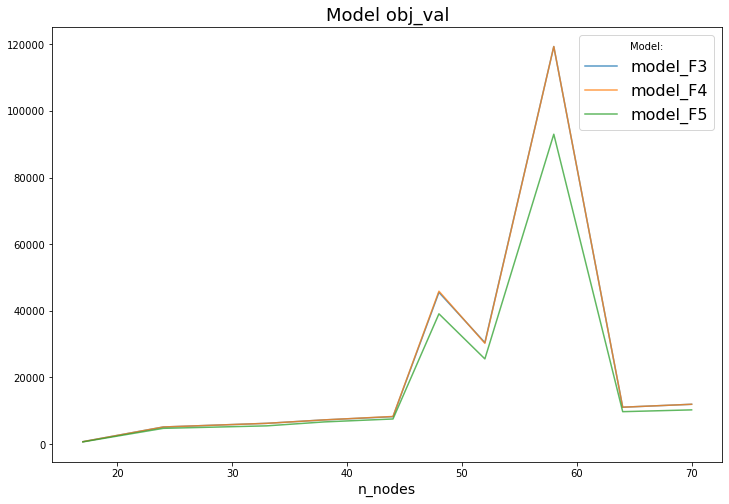

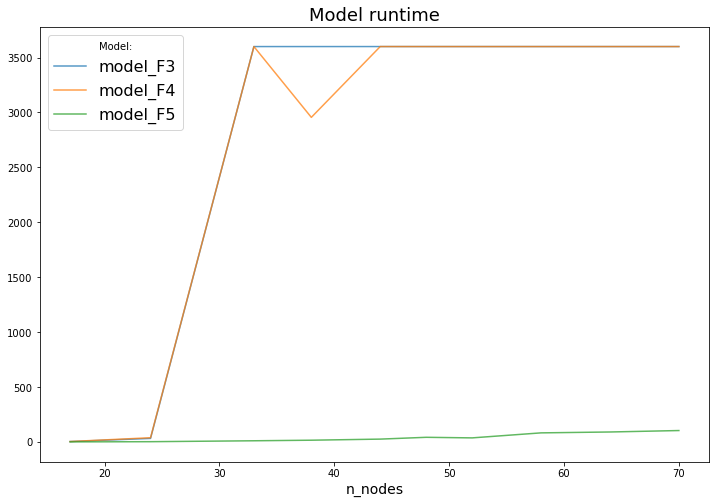

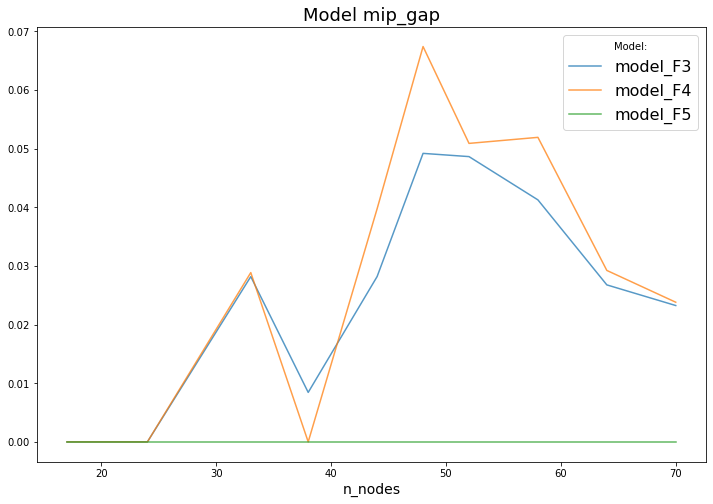

In [7]:
# plot the obj_val
show_plot("obj_val")

# plot the runtime
show_plot("runtime")

# plot the mip_gap
show_plot("mip_gap")

here we can observe:
- The performance of the model highly depends on the dataset it is applied on.
- F5 generally performs pretty well on Dataset_2 when $Q_k$ is not too large.
- The performance of F3 and F4 are quite similar in terms of runtime, MIP gap, and objective value.

# Conclusion

- The performance of the model highly depends on the dataset it is applied on.
- For F5, the number of required variables could not be enumerated when there are too many customers or when the capacity of vehicles is too high. However, F5 can perform pretty well with small dataset.
- The performance of F3 and F4 are generally quite similar in terms of runtime, MIP gap, and objective value. 
- F4 with original constraints performed better on Datasets_1 while F3 with original + bounding constraints performed slightly better on Datasets_2

# References

- Lahyani, R., Coelho, L.C. & Renaud, J. (2018) Alternative formulations and improved bounds for the multi‐depot fleet size and mix vehicle routing problem. OR Spectrum 40, 125–157

- Salhi S, Imran A, Wassan NA (2014) The multi-depot vehicle routing problem with heterogeneous vehicle fleet: formulation and a variable neighborhood search implementation. Comput Oper Res 52:315–325
